In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
%config InlineBackend.figure_format='png'

# 准备数据

In [2]:
dftrain_raw = pd.read_csv('/home/share/data/titanic/train.csv')
dftest_raw = pd.read_csv('/home/share/data/titanic/test.csv')
dftrain_raw.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
1,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C
2,388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0000,NaN,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
5,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
8,168,0,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S
9,752,1,3,"Moor, Master. Meier",male,6.0,0,1,392096,12.4750,E121,S


## 字段说明：
- Survived:0代表死亡，1代表存活【y标签】
- Pclass:乘客所持票类，有三种值(1,2,3) 【转换成onehot编码】
- Name:乘客姓名 【舍去】
- Sex:乘客性别 【转换成bool特征】
- Age:乘客年龄(有缺失) 【数值特征，添加“年龄是否缺失”作为辅助特征】
- SibSp:乘客兄弟姐妹/配偶的个数(整数值) 【数值特征】
- Parch:乘客父母/孩子的个数(整数值)【数值特征】
- Ticket:票号(字符串)【舍去】
- Fare:乘客所持票的价格(浮点数，0-500不等) 【数值特征】
- Cabin:乘客所在船舱(有缺失) 【添加“所在船舱是否缺失”作为辅助特征】
- Embarked:乘客登船港口:S、C、Q(有缺失)【转换成onehot编码，四维度 S,C,Q,nan】

## LABEL分布情况

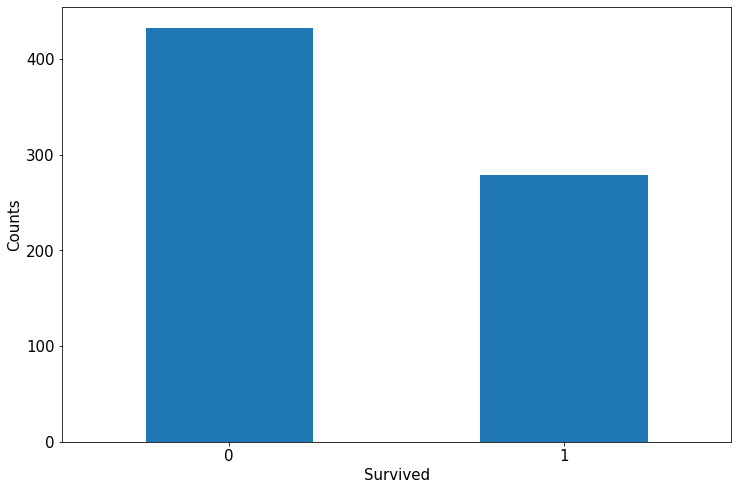

In [3]:
ax = dftrain_raw['Survived'].value_counts().plot(kind='bar', figsize=(12, 8), fontsize=15, rot=0)
ax.set_ylabel('Counts', fontsize=15)
ax.set_xlabel('Survived', fontsize=15)
plt.show()

## 年龄分布情况

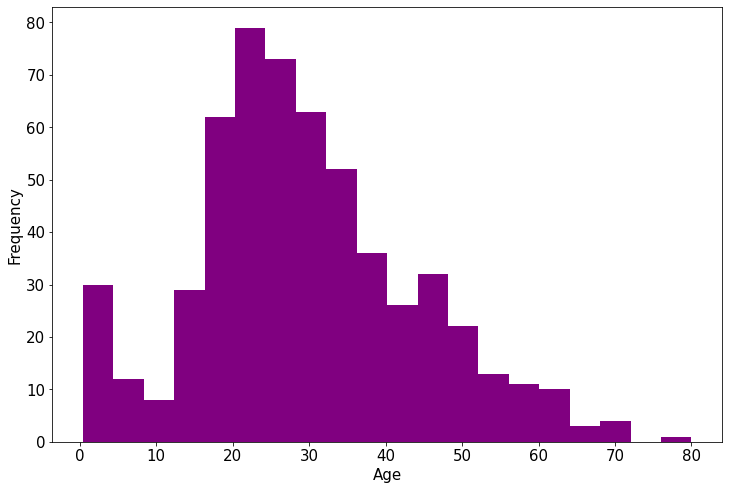

In [4]:
ax = dftrain_raw['Age'].plot(kind='hist', bins=20, color='purple', figsize=(12, 8), fontsize=15)
ax.set_ylabel('Frequency', fontsize=15)
ax.set_xlabel('Age', fontsize=15)
plt.show()

## 年龄个label的相关性

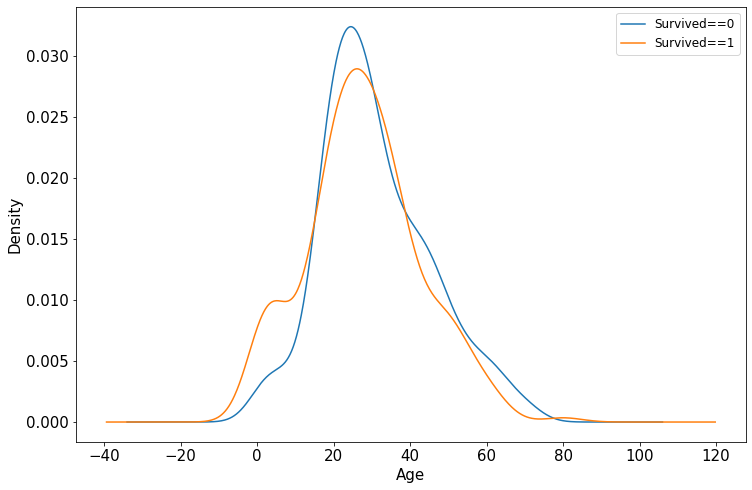

In [5]:
ax = dftrain_raw.query('Survived==0')['Age'].plot(kind='density', figsize=(12,8), fontsize=15)
dftrain_raw.query('Survived==1')['Age'].plot(kind='density', figsize=(12,8), fontsize=15)
ax.legend(['Survived==0', 'Survived==1'], fontsize=12)
ax.set_ylabel('Density', fontsize=15)
ax.set_xlabel('Age', fontsize=15)
plt.show()

In [6]:
dftrain_raw.query('Survived==0')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5000,C30,S
3,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S
4,687,0,3,"Panula, Mr. Jaako Arnold",male,14.0,4,1,3101295,39.6875,NaN,S
6,228,0,3,"Lovell, Mr. John Hall (""Henry"")",male,20.5,0,0,A/5 21173,7.2500,NaN,S
7,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
706,19,0,3,"Vander Planke, Mrs. Julius (Emelia Maria Vande...",female,31.0,1,0,345763,18.0000,NaN,S
708,65,0,1,"Stewart, Mr. Albert A",male,NaN,0,0,PC 17605,27.7208,NaN,C
709,130,0,3,"Ekstrom, Mr. Johan",male,45.0,0,0,347061,6.9750,NaN,S
710,21,0,2,"Fynney, Mr. Joseph J",male,35.0,0,0,239865,26.0000,NaN,S


## 预处理

In [9]:
def preprocessing(dfdata):
    dfresult = pd.DataFrame()
    #Pclass one-hot编码
    dfPclass = pd.get_dummies(dfdata['Pclass'])
    dfPclass.columns = ['Pclass_' + str(x) for x in dfPclass.columns]
    dfresult = pd.concat([dfresult, dfPclass], axis=1)
    
    # sex one-hot编码
    dfSex = pd.get_dummies(dfdata['Sex'])
    dfresult = pd.concat([dfresult, dfSex], axis=1)
    
    # Age 缺失值处理
    dfresult['Age'] = dfdata['Age'].fillna(0)
    dfresult['Age_null'] = pd.isna(dfdata["Age"]).astype('int32')
    
    # SibSp, Parch, Fare
    dfresult['SibSp'] = dfdata['SibSp']
    dfresult['Parch'] = dfdata['Parch']
    dfresult['Fare'] = dfdata['Fare']
    
    # Carbin
    dfresult['Cabin_null'] = pd.isna(dfdata['Cabin']).astype('int32')
    
    # Embarked
    dfEmbarked = pd.get_dummies(dfdata['Embarked'], dummy_na=True)
    dfEmbarked.columns = ['Embarked_' + str(x) for x in dfEmbarked.columns]
    dfresult = pd.concat([dfresult, dfEmbarked], axis=1)
    
    return dfresult

In [10]:
x_train = preprocessing(dftrain_raw)
y_train = dftrain_raw['Survived'].values

x_test = preprocessing(dftest_raw)
y_test = dftest_raw['Survived'].values

x_train.shape, x_test.shape

((712, 15), (179, 15))

# 定义模型

In [11]:
model = tf.keras.Sequential([
    keras.layers.Dense(20, activation='relu', input_shape=(15,)),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                320       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 541
Trainable params: 541
Non-trainable params: 0
_________________________________________________________________


# 训练模型

In [12]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC'])
history = model.fit(x_train, y_train, batch_size=64, epochs=50, validation_split=0.2)

Epoch 1/50
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
9/9 [==============================] - 1s 93ms/step - loss: 1.1458 - auc: 0.3222 - val_loss: 0.9950 - val_auc: 0.3752
Epoch 2/50
9/9 [==============================] - 0s 12ms/step - loss: 0.9232 - auc: 0.3583 - val_loss: 0.8060 - val_auc: 0.4154
Epoch 3/50
9/9 [==============================] - 0s 13ms/step - loss: 0.7383 - auc: 0.4549 - val_loss: 0.6737 - val_auc: 0.5781
Epoch 4/50
9/9 [==============================] - 0s 12ms/step - loss: 0.6447 - auc: 0.6890 - val_loss: 0.6457 - val_auc: 0.6671
Epoch 5/50
9/9 [==============================] - 0s 13ms/step - loss: 0.6342 - auc: 0.6994 - val_loss: 0.6437 - val_auc: 0.6609
Epoch 6/50
9/9 [==============================] - 0s 13ms/step - loss: 0.6252 - auc: 0.6974 - val_loss: 0.6350 - val_auc: 0.6628
Epoch 7/50
9/9 [==============================] - 1s 64ms/step - loss: 0.6151 - auc: 0.7041 - val_loss: 0.6313 - val_auc: 0.6660
Epoch 8/50
9/9 [

# 评估模型

In [13]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics)+1)
    plt.plot(epochs, train_metrics, 'bo--')
    plt.plot(epochs, val_metrics, 'ro-')
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

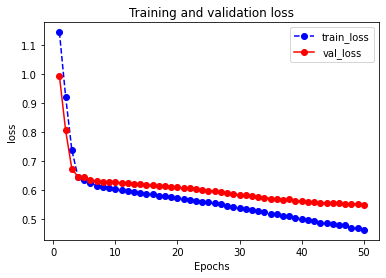

In [14]:
plot_metric(history, 'loss')

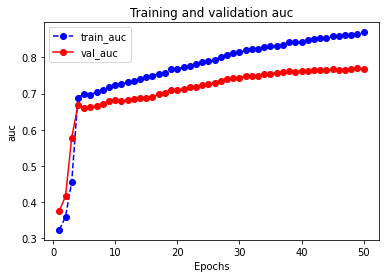

In [16]:
plot_metric(history, 'auc')

In [17]:
model.evaluate(x_test, y_test)

6/6 [==============================] - 0s 3ms/step - loss: 0.4624 - auc: 0.8537


[0.46239161491394043, 0.8537219762802124]

# 使用模型

In [20]:
model.predict(x_test[0:10])
# model(tf.constant(x_test[0:10].values, dtype=tf.float32)

array([[0.18185207],
       [0.49824357],
       [0.35315686],
       [0.8533662 ],
       [0.4566709 ],
       [0.59249943],
       [0.10811058],
       [0.6854962 ],
       [0.51915324],
       [0.14688002]], dtype=float32)

In [21]:
model.predict_classes(x_test[0:10])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0]], dtype=int32)

In [26]:
# np.argmax(model.predict(x_test[0:10]), axis=-1) #多分类
(model.predict(x_test[0:10]) >0.5).astype('int32')

array([[0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0]], dtype=int32)

# 保存模型

## Keras方式保存

### 保存模型结构及权重

In [29]:

model.save('../logs/keras_model.h5')
del model

In [30]:
model = tf.keras.models.load_model('../logs/keras_model.h5')
model.evaluate(x_test, y_test)

6/6 [==============================] - 0s 3ms/step - loss: 0.4624 - auc: 0.8537


[0.46239161491394043, 0.8537219762802124]

### 分别保存模型结构和权重

In [31]:
# 保存模型结构
json_str = model.to_json()
# 保存模型权重
model.save_weights('../logs/keras_model_weight.h5')

In [32]:
# 恢复模型结构
model_json = tf.keras.models.model_from_json(json_str)
model_json.compile(optimizer='adam',
                   loss='binary_crossentropy',
                  metrics=['AUC'])
# 加载权重
model_json.load_weights('../logs/keras_model_weight.h5')
model_json.evaluate(x_test, y_test)

6/6 [==============================] - 0s 3ms/step - loss: 0.4624 - auc: 0.8537


[0.46239161491394043, 0.8537219762802124]

## Tensorflow原生方式保存

In [33]:
model.save('../logs/tf_model_savemodel', save_format='tf')
print('export saved model')

INFO:tensorflow:Assets written to: ../logs/tf_model_savemodel/assets
export saved model


In [34]:
model_tf = tf.keras.models.load_model('../logs/tf_model_savemodel/')
model_tf.evaluate(x_test, y_test)

6/6 [==============================] - 0s 3ms/step - loss: 0.4624 - auc: 0.8537


[0.46239161491394043, 0.8537219762802124]